# Exploratory Data Analysis (EDA) for Social Sphere Project

## Project Overview

The **Social Sphere Project** aims to analyze social media usage patterns and their impact on mental health and sleep among different demographics. This notebook is dedicated to the Exploratory Data Analysis (EDA) phase, where we will gain insights into the dataset by examining the distributions and relationships among key variables. This analysis will help us understand the data better and prepare it for subsequent modeling phases.

## EDA Objectives

- **Profile Demographics**: Analyze age, gender, academic level, and country distributions.
- **Social-Media Behaviors**: Explore usage patterns and their relationships with mental health and sleep.
- **Target Variables**: Investigate patterns related to `Conflicts_Over_Social_Media` and `Addicted_Score`.
- **Cross-Country and Platform Analysis**: Assess differences across countries and platforms.
- **Data Preprocessing**: Handle missing values, encode categorical variables, detect outliers, and flag potential data biases.

## Structure

1. **Data Ingestion & Cleaning**: Load and clean the dataset, handle missing values, and prepare the data for analysis.
2. **Univariate Analysis**: Examine the distribution of individual variables.
3. **Bivariate/Multivariate Analysis**: Explore relationships between variables.
4. **Target-aware Exploration**: Analyze the distribution of target variables across demographics and behaviors.
5. **Bias & Outlier Detection**: Identify demographic skews and outliers.
6. **Pre-Clustering with PCA & UMAP**: Visualize naturally separated behavioral segments.

This EDA will provide a comprehensive understanding of the dataset, which is crucial for effective modeling and analysis in later stages.

# Libraries

In [3]:
%load_ext autoreload
%autoreload 2

# System & Data Handling
import os
import shutil
import pickle

# Data Loading
import kagglehub
import pandas as pd

# Plotting & Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import math

import numpy as np

import sys
sys.path.append('../src')
from utils import map_to_continent

# Constants
FIGSIZE = (16, 5)
FIGSIZE_LONG=(20, 6)
   

/opt/anaconda3/envs/c29env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Column Descriptions

- **Student_ID**: A unique integer identifier assigned to each survey respondent to enable de-duplication and track individual records without revealing personal information.  
- **Age**: The student’s age in completed years at the time of the survey, used to segment analysis by age group and control for developmental differences.  
- **Gender**: The student’s self-reported gender, recorded as “Male” or “Female” to allow for demographic breakdowns in usage and outcome measures.  
- **Academic_Level**: The highest level of education the respondent is currently enrolled in, with categories: “High School,” “Undergraduate,” or “Graduate,” facilitating stratified analyses by academic stage.  
- **Country**: The country of residence where the student completed the survey, enabling cross-country comparisons of social media behaviors and impacts.  
- **Avg_Daily_Usage_Hours**: The average number of hours per day the student spends on social media platforms, calculated from self-reported weekday and weekend usage estimates.  
- **Most_Used_Platform**: The social media platform on which the student spends the most time (e.g., Instagram, Facebook, TikTok), used to examine platform-specific effects.  
- **Affects_Academic_Performance**: A binary indicator (“Yes”/“No”) reflecting whether the student perceives their social media use as having a negative impact on their academic performance.  
- **Sleep_Hours_Per_Night**: The respondent’s average nightly sleep duration in hours, provided to investigate correlations between screen time and sleep quality/quantity.  
- **Mental_Health_Score**: A self-rated integer from 1 (poor) to 10 (excellent) indicating overall mental well-being, allowing assessment of potential associations with social media habits.  
- **Relationship_Status**: The student’s current romantic relationship status, categorized as “Single,” “In Relationship,” or “Complicated,” to explore social media’s impact on interpersonal dynamics.  
- **Conflicts_Over_Social_Media**: The number of arguments or disagreements the student reports having had with family, friends, or partners due to their social media use, serving as a proxy for social friction.  
- **Addicted_Score**: A composite score from 1 (low addiction) to 10 (high addiction) based on a standardized survey scale (e.g., Bergen Social Media Addiction Scale), quantifying the degree of problematic usage.

Features relying on student's self-perception:
- **Mental_Health_Score**
- **Relationship_Status**
- **Affects_Academic_Performance**  
This features are based on the student's self-perception and are not directly observable. We should be careful with the interpretation of these features and analyze their impact on the models predictions.

# Extracting and Loading the Data

The dataset is sourced from Kaggle and contains information about social media usage patterns, demographics, and their impact on mental health and relationships. It includes various features such as age, gender, academic level, country, daily usage hours, preferred platforms, and metrics related to mental health and addiction scores.

In [4]:
# Download latest version
path = kagglehub.dataset_download("adilshamim8/social-media-addiction-vs-relationships")

print("Path to dataset files:", path)

file = os.listdir(path)[0]
file_path = os.path.join(path, file)
# copy the file to data folder
shutil.copy(file_path, "../data/data.csv")

df_data = pd.read_csv("../data/data.csv")
df_data.head()

Path to dataset files: /Users/bobhosseini/.cache/kagglehub/datasets/adilshamim8/social-media-addiction-vs-relationships/versions/3


,Student_ID,Age,Gender,Academic_Level,Country,Avg_Daily_Usage_Hours,Most_Used_Platform,Affects_Academic_Performance,Sleep_Hours_Per_Night,Mental_Health_Score,Relationship_Status,Conflicts_Over_Social_Media,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


In [5]:
# Column name refactoring
df_data.rename(columns={
    'Sleep_Hours_Per_Night': 'Sleep_Hrs',
    'Social_Media_Usage_Hours': 'Soc_Media_Usage',
    'Avg_Daily_Usage_Hours': 'Daily_Usage',
    'Conflicts_Over_Social_Media': 'Conflicts',
    'Mental_Health_Score': 'Mental_Health',
    # 'Addicted_Score': 'Adcdicted_Score',
    # 'Relationship_Status': 'Rel_Status',
    'Affects_Academic_Performance': 'Academic_Affects',
    'Most_Used_Platform': 'Platform'
    # 'Academic_Level': 'Acad_Level'
}, inplace=True)

df_data.head()

,Student_ID,Age,Gender,Academic_Level,Country,Daily_Usage,Platform,Academic_Affects,Sleep_Hrs,Mental_Health,Relationship_Status,Conflicts,Addicted_Score
0,1,19,Female,Undergraduate,Bangladesh,5.2,Instagram,Yes,6.5,6,In Relationship,3,8
1,2,22,Male,Graduate,India,2.1,Twitter,No,7.5,8,Single,0,3
2,3,20,Female,Undergraduate,USA,6.0,TikTok,Yes,5.0,5,Complicated,4,9
3,4,18,Male,High School,UK,3.0,YouTube,No,7.0,7,Single,1,4
4,5,21,Male,Graduate,Canada,4.5,Facebook,Yes,6.0,6,In Relationship,2,7


# Check the data shape, null values
- There are 705 rows and 13 columns in the dataset.
- No null values exist in any of the columns.

In [6]:
# check the data shape, null values, and column types
print("data shape: ", df_data.shape)
df_data.info()

data shape:  (705, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 705 entries, 0 to 704
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Student_ID           705 non-null    int64  
 1   Age                  705 non-null    int64  
 2   Gender               705 non-null    object 
 3   Academic_Level       705 non-null    object 
 4   Country              705 non-null    object 
 5   Daily_Usage          705 non-null    float64
 6   Platform             705 non-null    object 
 7   Academic_Affects     705 non-null    object 
 8   Sleep_Hrs            705 non-null    float64
 9   Mental_Health        705 non-null    int64  
 10  Relationship_Status  705 non-null    object 
 11  Conflicts            705 non-null    int64  
 12  Addicted_Score       705 non-null    int64  
dtypes: float64(2), int64(5), object(6)
memory usage: 71.7+ KB


## Null values inspection
The dataset has no null values.


In [7]:
# check if any column has null values
if df_data.isnull().sum().any():
    print("null values: ", df_data.isnull().sum())
else:
    print("no null values")

no null values


# Inspecting duplicates
- There are no duplicate rows or duplicates by Student_ID in the dataset.

In [8]:
# inspecting duplicates

print(f"Number of duplicate rows: {df_data.duplicated().sum()}")

# inspecting duplicates by Student_ID
print(f"Number of duplicates by Student_ID: {len(df_data[df_data.duplicated(subset=['Student_ID'])].index)}")


Number of duplicate rows: 0
Number of duplicates by Student_ID: 0


# Inspecting Column types
- Column types are set to the correct data types.
- The **categorical columns** are 'Gender', 'Academic_Level', 'Country', 'Most_Used_Platform', 'Affects_Academic_Performance', 'Relationship_Status'
- The **numerical columns** are 'Age', 'Sleep_Hours_Per_Night', 'Social_Media_Usage_Hours', 'Conflicts_Over_Social_Media', 'Addicted_Score'
- The student_id is dropped as it is not a relevant feature for the analysis.

In [9]:
cat_cols = df_data.select_dtypes(include=['object']).columns
cat_cols = [col for col in cat_cols if col not in ['Date', 'Time']]
num_cols = df_data.select_dtypes(include=['int64', 'float64']).columns.drop('Student_ID').tolist()


print('categorical columns: \n', cat_cols)
print('\n numerical columns: \n', num_cols)

categorical columns: 
 ['Gender', 'Academic_Level', 'Country', 'Platform', 'Academic_Affects', 'Relationship_Status']

 numerical columns: 
 ['Age', 'Daily_Usage', 'Sleep_Hrs', 'Mental_Health', 'Conflicts', 'Addicted_Score']


# Inspecting the summary statistics
- The age range is from 18 to 24, which is consistent with the target population of students aged 16–25. The average age is ~20.
- The participants spend ~4.9 hours on social media per day, ranging from 1.5 to 8.5 hours.
- The average sleep duration is ~6.8 hours, ranging from 4 to 12 hours.
- The average conflicts over social media score is ~2.8, ranging from 0 to 5.
- The average addicted score is ~1.5, ranging from 2 to 9.


In [10]:
# Get summary statistics for numerical columns
df_data.describe()

,Student_ID,Age,Daily_Usage,Sleep_Hrs,Mental_Health,Conflicts,Addicted_Score
count,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000,705.000000
mean,353.000000,20.659574,4.918723,6.868936,6.226950,2.849645,6.436879
std,203.660256,1.399217,1.257395,1.126848,1.105055,0.957968,1.587165
min,1.000000,18.000000,1.500000,3.800000,4.000000,0.000000,2.000000
25%,177.000000,19.000000,4.100000,6.000000,5.000000,2.000000,5.000000
50%,353.000000,21.000000,4.800000,6.900000,6.000000,3.000000,7.000000
75%,529.000000,22.000000,5.800000,7.700000,7.000000,4.000000,8.000000
max,705.000000,24.000000,8.500000,9.600000,9.000000,5.000000,9.000000


- Data has no duplicates.

In [11]:
# Check for duplicates
print(f'Number of duplicates: {df_data.duplicated().sum()}')

Number of duplicates: 0


# Categorical columns
- The data is collected from ~100 countries.
- Academic levels are: 'Undergraduate', 'Graduate', 'High School'
- Gender: 'Female', 'Male'
- Most used platforms are: 'Instagram', 'Twitter', 'TikTok', 'YouTube', 'Facebook', 'LinkedIn', 'Snapchat', 'LINE', 'KakaoTalk', 'VKontakte', 'WhatsApp', 'WeChat'
- Affects Academic Performance: 'Yes', 'No'
- Relationship Status: 'In Relationship', 'Single', 'Complicated'

In [12]:
# unique values
for col in cat_cols:
    n_unique = df_data[col].nunique()
    print(f'. {col}: has {n_unique} unique values')
    if n_unique < 20:
        print(f'   Unique values in {col}: {df_data[col].unique()}')


. Gender: has 2 unique values
   Unique values in Gender: ['Female' 'Male']
. Academic_Level: has 3 unique values
   Unique values in Academic_Level: ['Undergraduate' 'Graduate' 'High School']
. Country: has 110 unique values
. Platform: has 12 unique values
   Unique values in Platform: ['Instagram' 'Twitter' 'TikTok' 'YouTube' 'Facebook' 'LinkedIn' 'Snapchat'
 'LINE' 'KakaoTalk' 'VKontakte' 'WhatsApp' 'WeChat']
. Academic_Affects: has 2 unique values
   Unique values in Academic_Affects: ['Yes' 'No']
. Relationship_Status: has 3 unique values
   Unique values in Relationship_Status: ['In Relationship' 'Single' 'Complicated']


# Data distribution
- Here we study the distribution of each feature in the dataset.
- We look for under-represented categoriesm, outliers, and skewness issues

In [36]:
# Set plot style
sns.set(style="whitegrid")

def plot_distributions(df, variables, plot_type='histogram'):
    """
    Plot distributions for a list of variables in a DataFrame.

    Parameters:
    - df: pandas DataFrame containing the data
    - variables: list of column names to plot
    - plot_type: 'histogram' for continuous variables, 'countplot' for categorical variables
    """
    n_cols = 3
    n_rows = math.ceil(len(variables) / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten()  # Flatten in case of single row

    for i, var in enumerate(variables):
        if plot_type == 'histogram':
            sns.histplot(df[var], bins=30, binwidth=.3, kde=True, ax=axes[i])
            axes[i].set_title(f'Distribution of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frequency')
        elif plot_type == 'countplot':
            sns.countplot(data=df, x=var, order=df[var].value_counts().index, ax=axes[i])
            axes[i].set_title(f'Countplot of {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Count')
            axes[i].tick_params(axis='x', rotation=45)

    # Hide unused subplots (if any)
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

## Histograms for numerical variables
- Continuous variables have almost normal distributions based on the visual inspections.

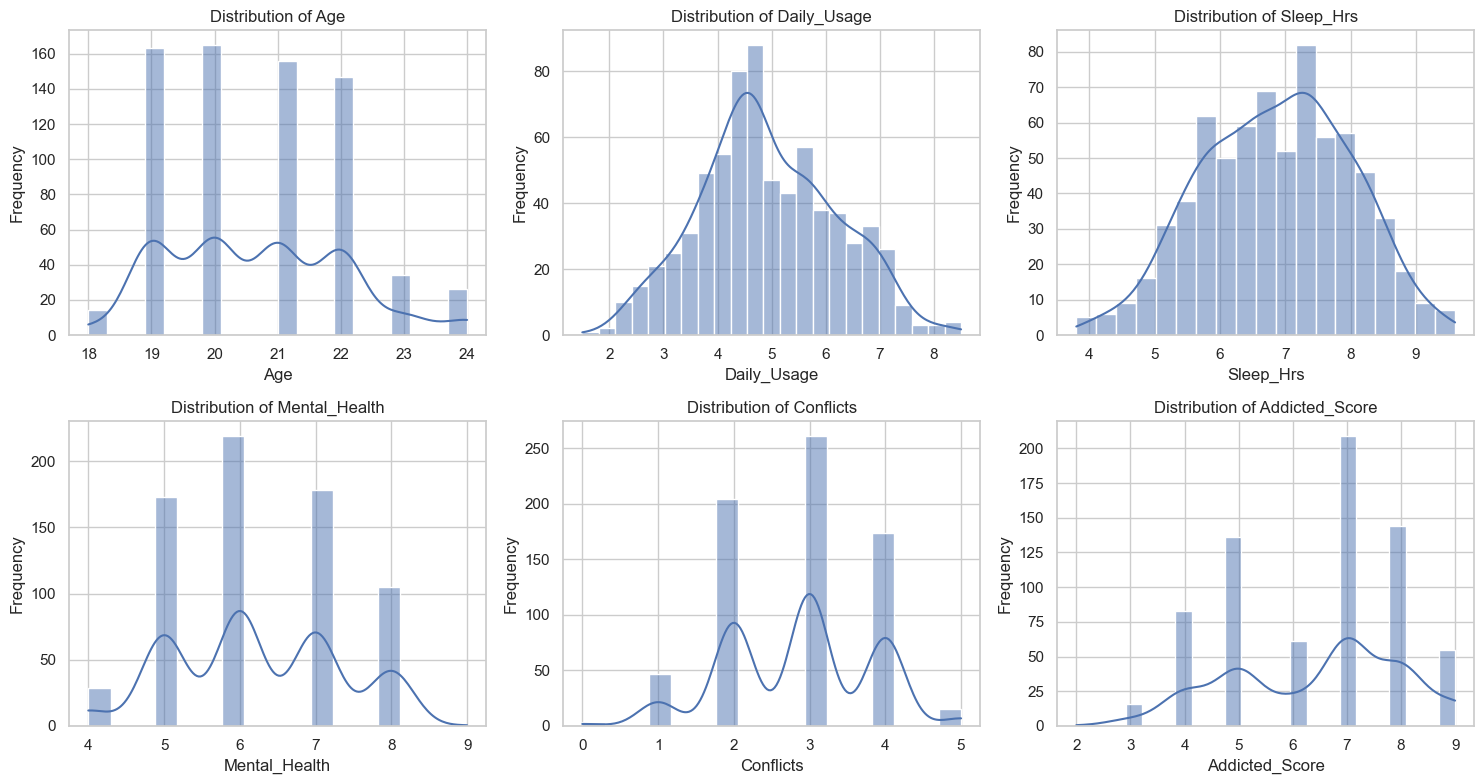

In [14]:
plot_distributions(df_data, num_cols, plot_type='histogram')


## Skewness calculation
- The skew function for 'Avg_Daily_Usage_Hours' and 'Sleep_Hours_Per_Night' is relatively close to 0, indicating that the distributions are close to normal.

In [15]:
from scipy.stats import skew
skew_cols = ['Daily_Usage', 'Sleep_Hrs']
for var in skew_cols:
    val = df_data[var].dropna()
    sk = skew(val)
    print(f"{var}: Skewness = {sk:.2f}")

Daily_Usage: Skewness = 0.16
Sleep_Hrs: Skewness = -0.11


## Countplots for categorical variables
- The data is balanced between the genders, males and females are almost equal.
- We have almost equal number of undergraduates and graduates (~325), but fewer high school students (~27).
    - This may lead to high school students being under-represented in the dataset and may cause bias.
- The majority of the participants are from India, USA, and Canada. 
    - There are ~80 countries with only 1 participant.
    - Besides the bias, this may lead to overfitting in the modeling step.
    - Possible options are:
        - grouping the countries into regions or continents, 
        - dropping the countries with only 1 participant.
        - frequency encoding the countries.
- Students mostly use Instagram, Facebook, TikTok, and slightly less WhatsApp, while the rest of the platforms are used by 10-30 students with YouTube being the least used platform.
    - Possibly this long tail distribution must be trimmed in the feature engineering step to avoid overfitting.
    - Can be grouped into a few categories, or based on platform-type (social media, messaging, etc.)

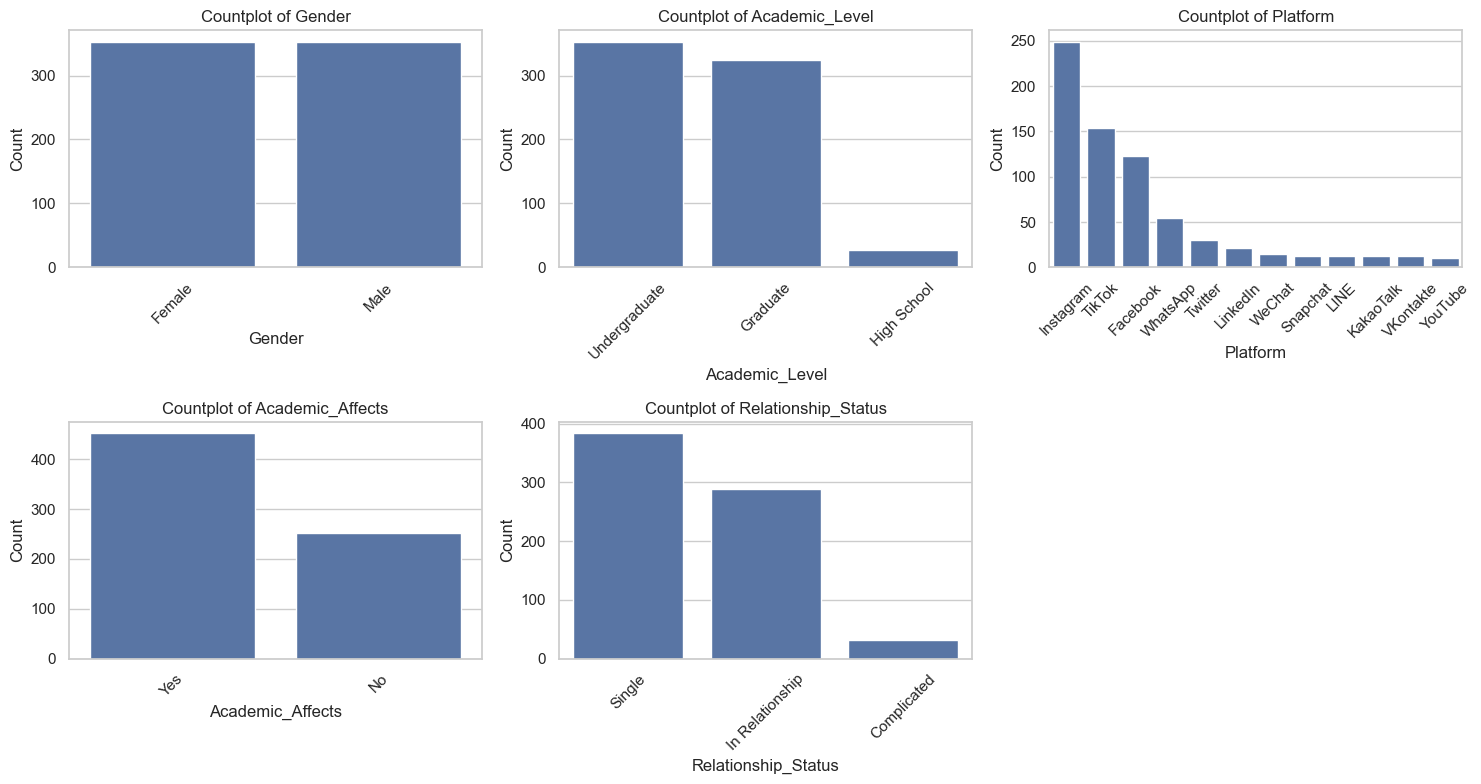

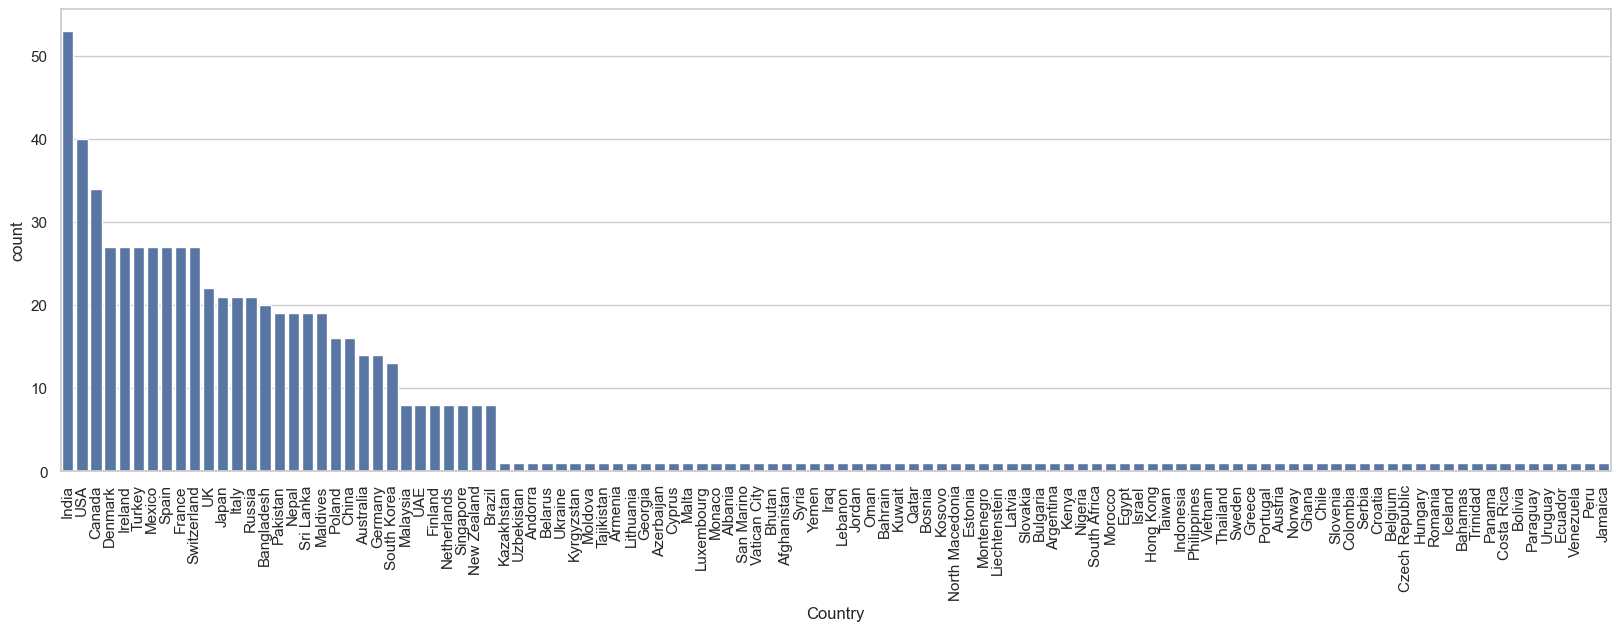

In [16]:
# countplots for categorical variables
count_plot_vars = cat_cols.copy()
count_plot_vars.remove('Country')
plot_distributions(df_data, count_plot_vars, plot_type='countplot')

# plot the countplot for the country
plt.figure(figsize=FIGSIZE_LONG)  # Set a wide figure size for better visualization

sns.countplot(data=df_data, x='Country', order=df_data['Country'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

## Category Balance in the Dataset
- "Complicated" relationship status is underrepresented.
- High school students are underrepresented.
- 7 out of 12 platforms have fewer than 21 participants.
- 79 out of 110 countries have only one participant.

In [17]:
print(df_data['Relationship_Status'].value_counts(), end='\n\n')
print(df_data['Academic_Level'].value_counts(), end='\n\n')
print(df_data['Platform'].value_counts(), end='\n\n')
print('number of countries with more than 1 participant: ', sum(df_data['Country'].value_counts()>1))
print('number of countries with only 1 participant: ', sum(df_data['Country'].value_counts()==1))

Relationship_Status
Single             384
In Relationship    289
Complicated         32
Name: count, dtype: int64

Academic_Level
Undergraduate    353
Graduate         325
High School       27
Name: count, dtype: int64

Platform
Instagram    249
TikTok       154
Facebook     123
WhatsApp      54
Twitter       30
LinkedIn      21
WeChat        15
Snapchat      13
LINE          12
KakaoTalk     12
VKontakte     12
YouTube       10
Name: count, dtype: int64

number of countries with more than 1 participant:  31
number of countries with only 1 participant:  79


# Outlier Detection

## Visual inspection using boxplots
- We use boxplots to inspect the outliers visually.
- In the boxplot, we can see that there are few outliers in the 'Avg_Daily_Usage_Hours'column.

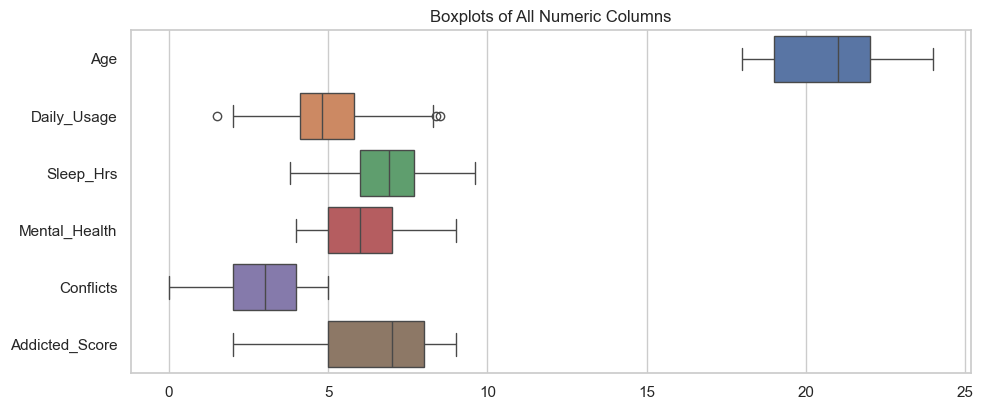

In [18]:

plt.figure(figsize=(10, len(num_cols) * .71))  # Dynamically adjust height
sns.boxplot(data=df_data[num_cols], orient='h')  # Horizontal boxplots for each column
plt.title('Boxplots of All Numeric Columns')
plt.tight_layout()
plt.show()

## Inspecting the outlier samples
- We use the IQR method to detect the outliers.
- The IQR method flags 3 potential outliers in the 'Avg_Daily_Usage_Hours' column where the student's daily usage was 1.5, and ~8.5 hours.

In [19]:
column_name = 'Daily_Usage'
def find_outliers(df_data, column_name):
    Q1 = df_data[column_name].quantile(0.25)
    Q3 = df_data[column_name].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outliers = df_data[(df_data[column_name] < lower_bound) | (df_data[column_name] > upper_bound)]

    # Inspect outliers
    if len(outliers) > 0:
        print(outliers[['Student_ID', column_name]])
    else:
        print(f"No outliers found in {column_name}")

for column_name in num_cols:
    find_outliers(df_data, column_name)

No outliers found in Age
     Student_ID  Daily_Usage
6             7          1.5
486         487          8.4
496         497          8.5
No outliers found in Sleep_Hrs
No outliers found in Mental_Health
No outliers found in Conflicts
No outliers found in Addicted_Score


## Outlier removal
We use the IQR method to remove outliers from the dataset.

In [20]:
# removing outliers using IQR method

# define a function to remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR)))]
    return df

# remove outliers from the dataset
df_data = remove_outliers_iqr(df_data, num_cols)

# print the number of rows in the dataset
print(f"Number of rows in the original dataset: {len(df_data)}")
print(f"Number of rows in the dataset: {len(df_data)}")

Number of rows in the original dataset: 702
Number of rows in the dataset: 702


# Saving the cleaned dataset
The cleaned dataset is saved in the data folder for modeling phase.

In [21]:
# saving the cleaned dataset using pickle

# save the cleaned dataset
df_data.to_pickle('../data/data_cleaned.pickle')

# Correlation matrices for numerical features
- A strong positive correlation between 'Conflicts_Over_Social_Media' and 'Daily_Usage', 
- A strong negative correlation between 'Conflicts_Over_Social_Media' and 'Mental_Health'.
    - However, the mental health score is determined by the student's self-perception, which may not be externally observable.
- A mederate negative correlation between 'Conflicts_Over_Social_Media' and 'Sleep_Hours'.

- Similar patterns are observed for 'Addicted_Score' and the input features.
- A strong linear correlation between 'Daily_Usage_Hours', 'Mental_Health', and 'Sleep_Hours'.

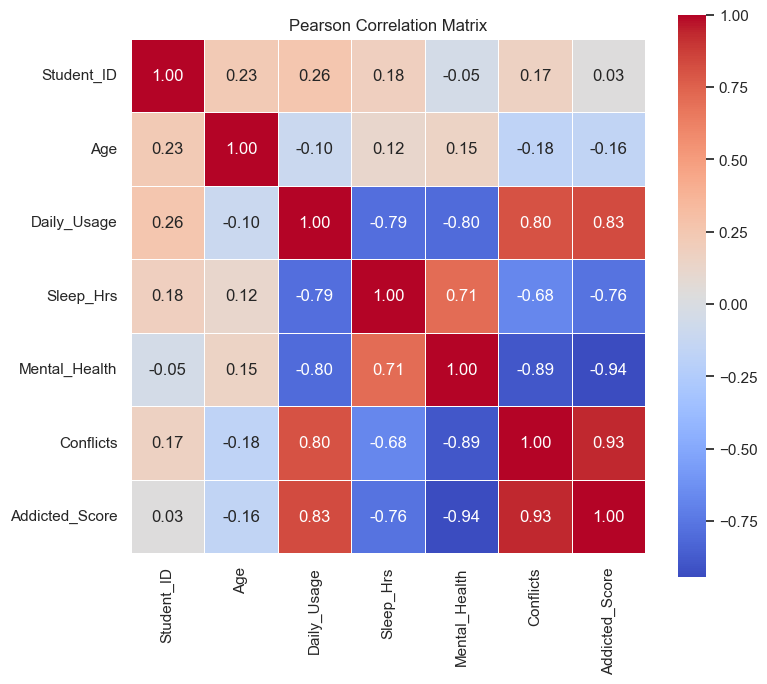

In [22]:
# Get numerical columns
numerical_cols = df_data.select_dtypes(include=['int64', 'float64']).columns.tolist()

def plot_correlation_matrix(df_data, numerical_cols, method='pearson'):
    # Compute correlation matrix
    corr_pearson = df_data[numerical_cols].corr(method=method)
    corr_spearman = df_data[numerical_cols].corr(method=method)

    # Plot correlation heatmap
    plt.figure(figsize=(8, 8))
    # mask = np.triu(np.ones_like(corr_pearson, dtype=bool))
    sns.heatmap(corr_pearson, annot=True, fmt=".2f", cmap="coolwarm", 
                square=True, linewidths=.5, cbar_kws={"shrink": .8})
    plt.title(f'{method.capitalize()} Correlation Matrix')
    plt.tight_layout()
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Plot Pearson correlation heatmap
plot_correlation_matrix(df_data, numerical_cols, method='pearson')

# Scatter Plots for Relationship Insights
- The plots indicate that both the addiction score and conflicts are positively correlated with Daily Usage.
- Conversely, they exhibit a negative correlation with Sleep Hours and Mental Health.
- There is no clear relationship between conflicts and addiction score with Age of students.

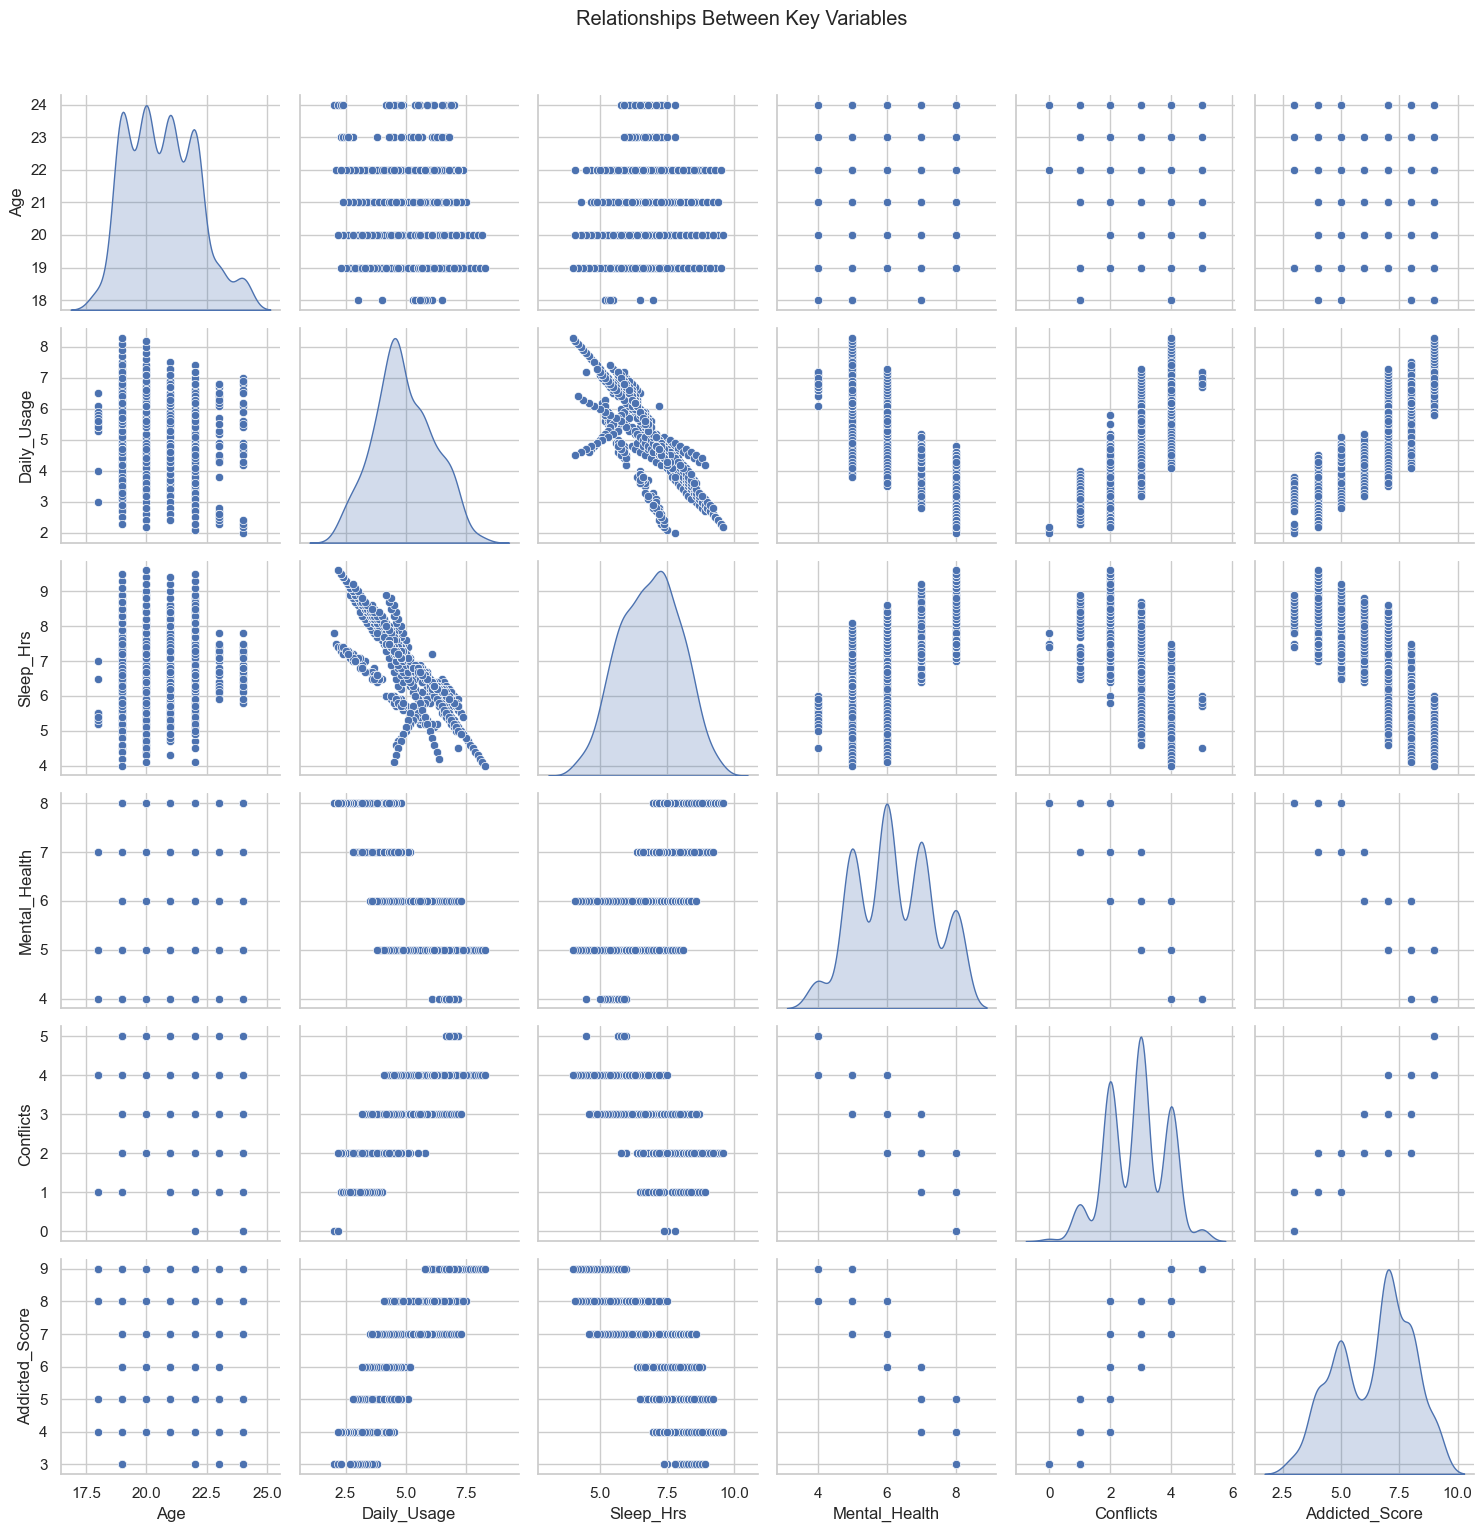

In [23]:
# Pairplot for selected features
selected_features = ['Daily_Usage', 'Sleep_Hrs', 
                     'Mental_Health', 'Addicted_Score']
sns.pairplot(df_data[num_cols], diag_kind='kde')
plt.suptitle('Relationships Between Key Variables', y=1.02)
plt.tight_layout()
plt.show()

 # Distribution of Addicted Score by Categorical features:
 - gender, country, or platform.
 
 **Observations:**
 1. **Gender**:
   - The median addiction score is the same for males and females, however, female participants have more variability in their scores.

2. **Academic Level**:
   - The median of addicted score is close for all academic levels, between 7 and 8
   - However, high school student samples contain outliers and generally have higher addicted scores.
   - This observation might be due to the under-representation of high school students in the dataset.
 
3. **Academic Affects**:
   - Those who reported academic affects have a higher median addiction score.
   - This strong correlation might be due to the self-reported nature of the question about academic affects.

4. **Relationship Status**:
   - Single individuals have a higher median addiction score compared to those in a relationship.
   - Those in complicated relationships have a similar median addiction score compared to single participants, but most of them report higher addiction scores overall.
   - This observation might be due to the under-representation of complicated relationship status in the dataset.
   - The complicated group show outlier samples.

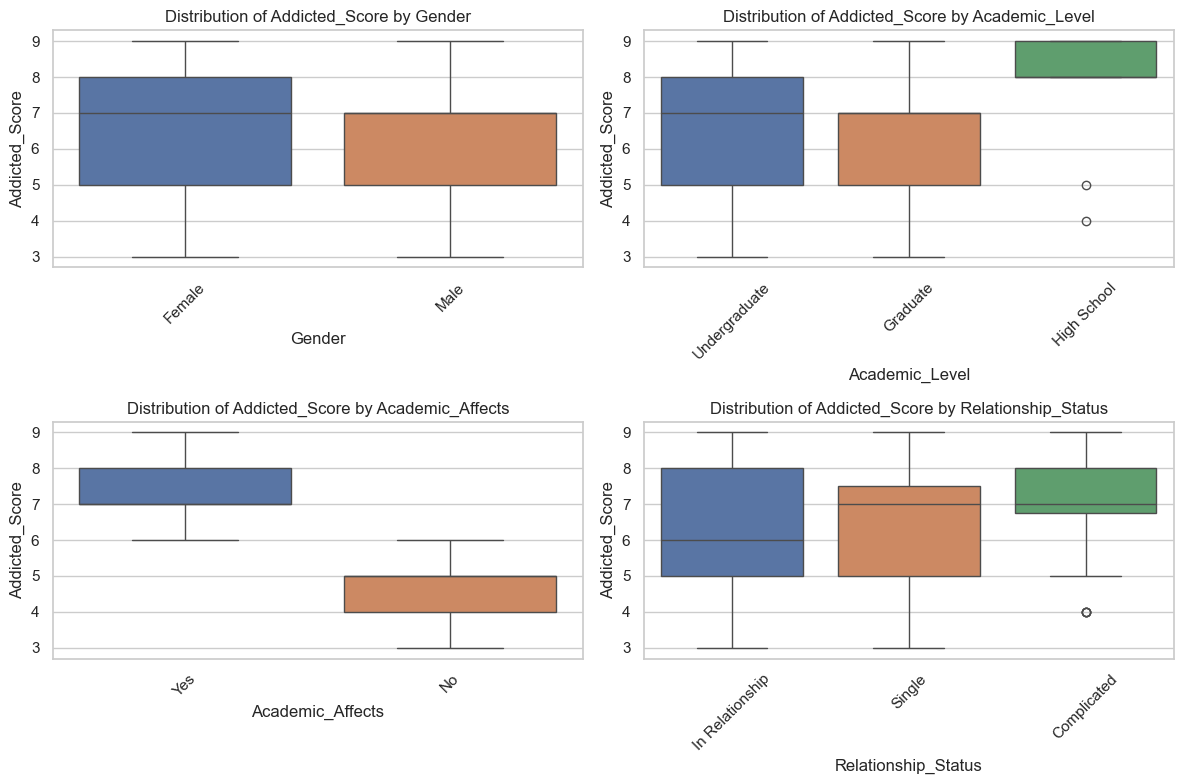

In [24]:
# Assuming 'df_data' is your DataFrame and 'cat_cols' is your list of categorical columns
boxplot_cols = cat_cols.copy()
boxplot_cols.remove('Country')
boxplot_cols.remove('Platform')

def boxplot_by_category(df, boxplot_cols, target_col):
    # Determine the number of rows and columns for the subplots
    n_cols = 2  # Number of columns in the subplot grid
    n_rows = (len(boxplot_cols) + n_cols - 1) // n_cols  # Calculate the number of rows needed

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 6, n_rows * 4))
    axes = axes.flatten()  # Flatten the axes array for easy iteration

    for i, col in enumerate(boxplot_cols):
        n_cat = len(df[col].unique())
        sns.boxplot(data=df, x=col, y=target_col, hue=col, ax=axes[i])
        axes[i].set_title(f'Distribution of {target_col} by {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel(target_col)
        axes[i].tick_params(axis='x', rotation=45)

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()

boxplot_by_category(df_data, boxplot_cols, 'Addicted_Score')


## Features with long-tail distributions:

1. **Most Used Platforms**:
    - People on Instagram and Twitter have a wider range of addiction scores compared to others with a relatively high median.
    - Among popular platforms, Instagram, Tiktok, and WhatsApp have the highest median addiction scores. 
        - Tiktok: median = 8, WhatsApp: median = 7, Instagram: median = 7
    - Tiktok and WhatsApp users have a comparable spread of addiction scores which are mostly high.
    - Some outliers are observed in the Tiktok group.
    - Other less popular platforms such as Snapchat, WeChat, Line, etc does not have enough data samples to make any strong statistical conclusions.

2. **Countries (with more than 1 participant)**:
    - USA shows the **highest addiction** scores with a median of 9 (maximum).
    - India, Turkey, Mexico, Spain, and UK show similar spread of addiction scores. They are in the **2nd tier** after USA.
    - Japan shows the **lowest addiction** scores spread among all well-represented countries.
    - Countries like Switzerland, Denmark, Germany, France, and Australia are in the **middle tier**.
    - The rest of the coutries show above average addiction score spreads.
    - The countries with less than 10 participants show a binary distribution of addiction scores which may indicate sampling bias. 
      - It's important to treat this feature with care in the modeling step.

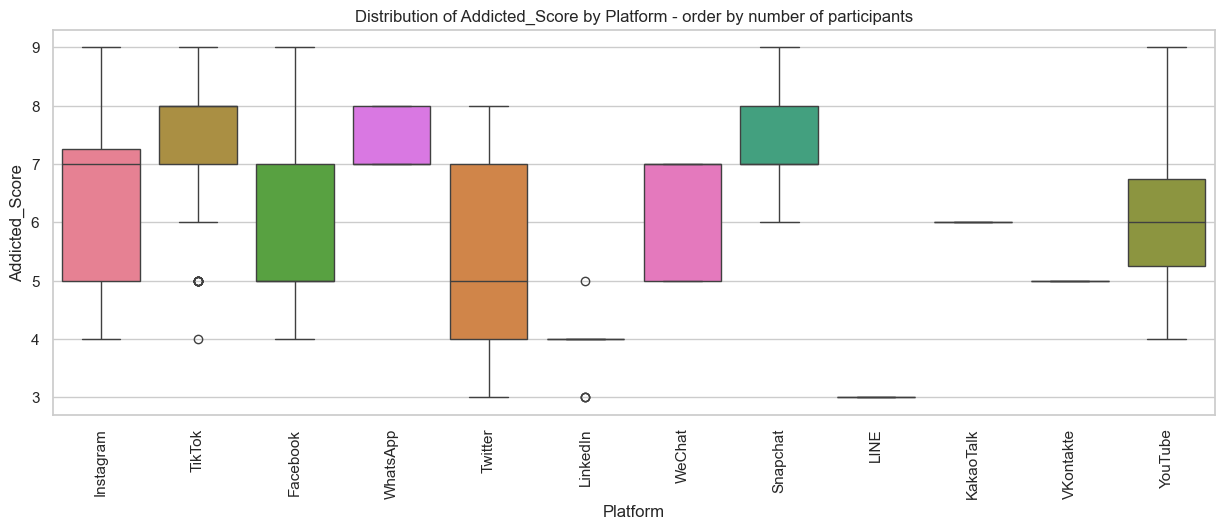

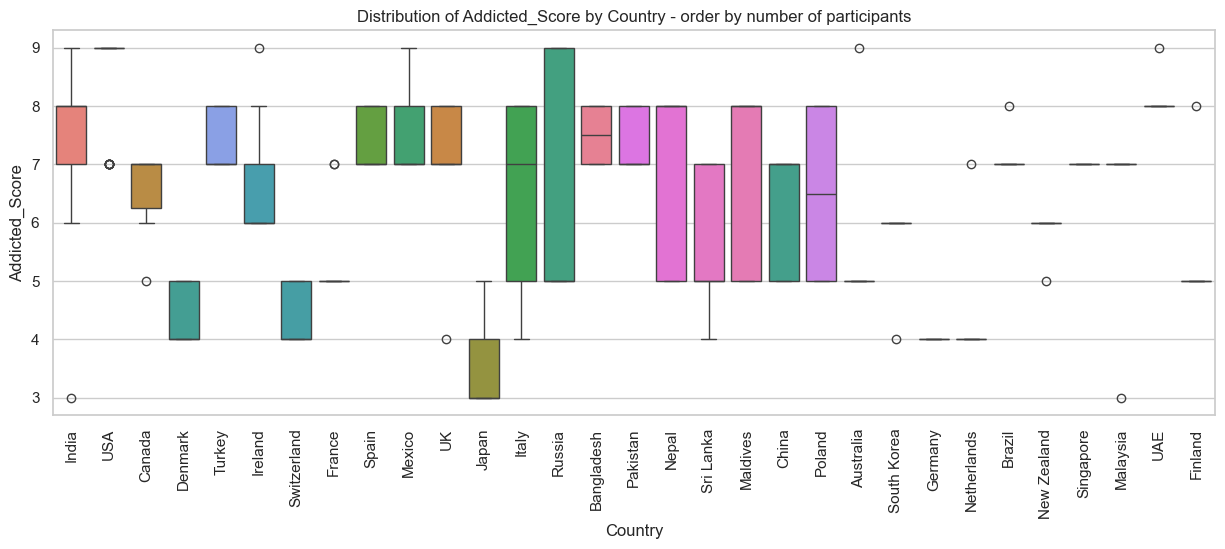

In [25]:
# plot Platform separately
def boxplot_by_category_long_tail(df, cat_cols, target_col):
    plt.figure(figsize=(15, 5))
    sns.boxplot(data=df, x=cat_cols, y=target_col, hue=cat_cols, order=df[cat_cols].value_counts().index)
    plt.title(f'Distribution of {target_col} by {cat_cols} - order by number of participants')
    plt.xlabel(cat_cols)
    plt.ylabel(target_col)
    plt.xticks(rotation=90)
    plt.show()

boxplot_by_category_long_tail(df_data, 'Platform', 'Addicted_Score')

# boxplot for countries with more than 1 participant
df_data_country = df_data[df_data['Country'].isin(df_data['Country'].value_counts()[df_data['Country'].value_counts() > 1].index)]
boxplot_by_category_long_tail(df_data_country, 'Country', 'Addicted_Score')

 # Distribution of Conflicts over Social Media by Categorical features:
 - gender, country, or platform.
 
**Observations:**
- The boxplots show distributions similar to the addiction score boxplots.
- The conflicts distributions for high school students and those with no academic affects have a tight spread.
- The conflicts are more similar among the 3 relationship status groups compared to their reported addiction scores.

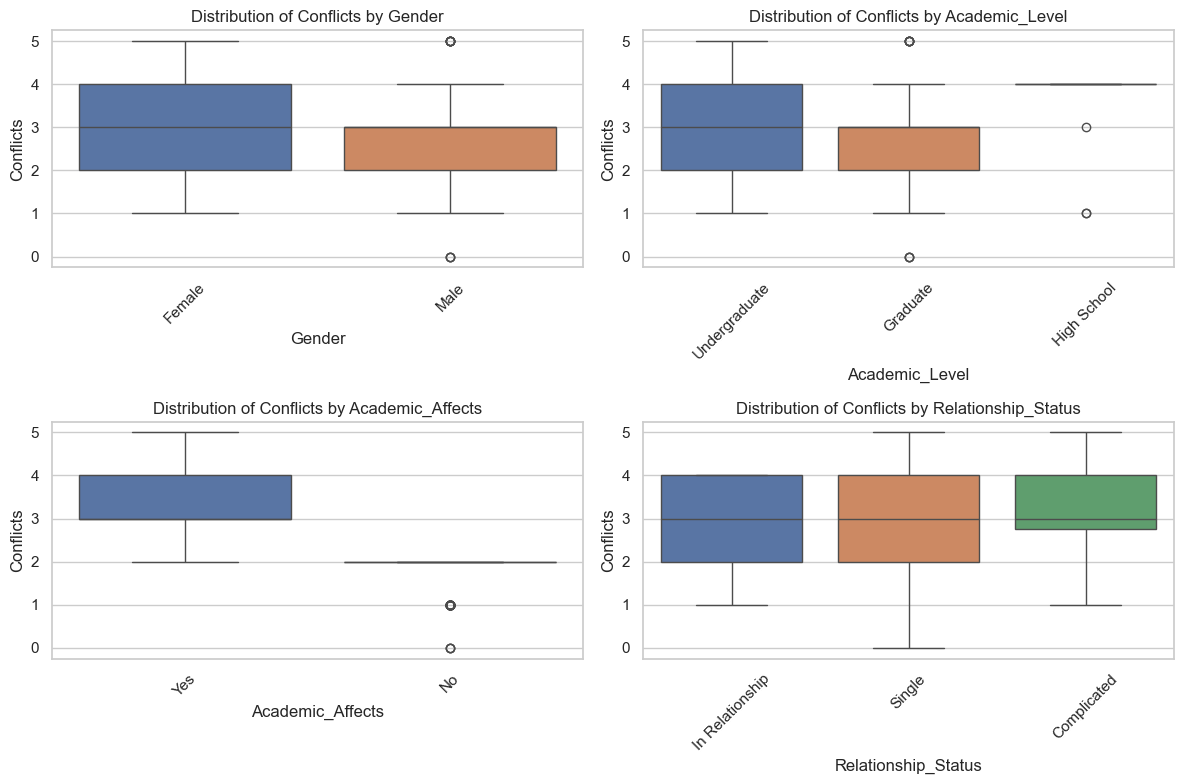

In [26]:
boxplot_by_category(df_data, boxplot_cols, 'Conflicts')

## Features with long-tail distributions:
- For Most Used Platforms and Countries the distributions of Social Media Conflicts are similar to the Addicted Score distributions.
- However, Instagram users show relatively less conflicts compared to their addiction scores next to other platforms. 
- Among countries, Ireland, Denmark, Switzerland, and Canada show a tight conflict spread compared to their addiction scores. 

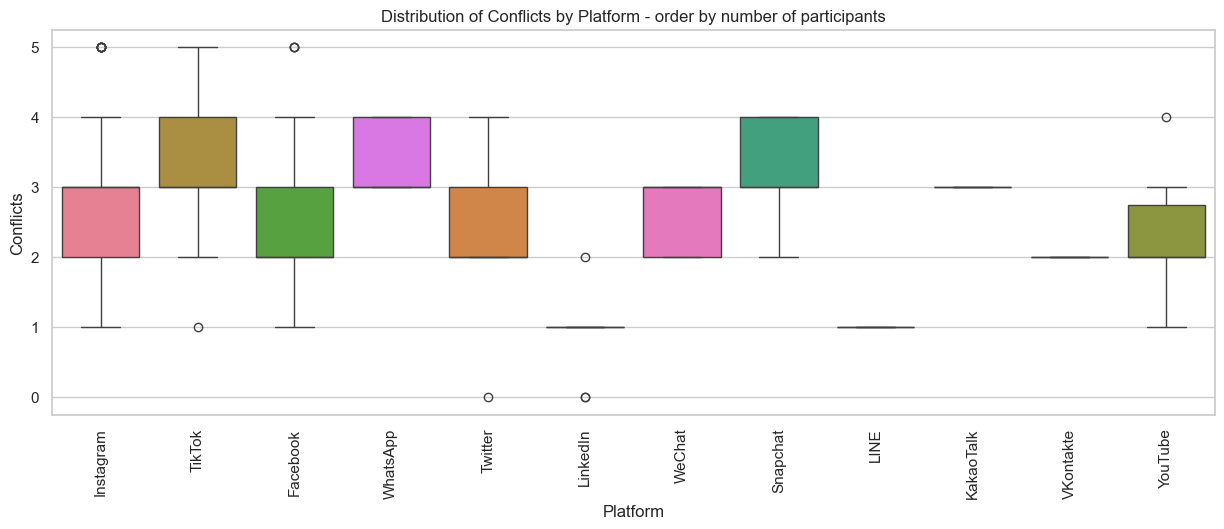

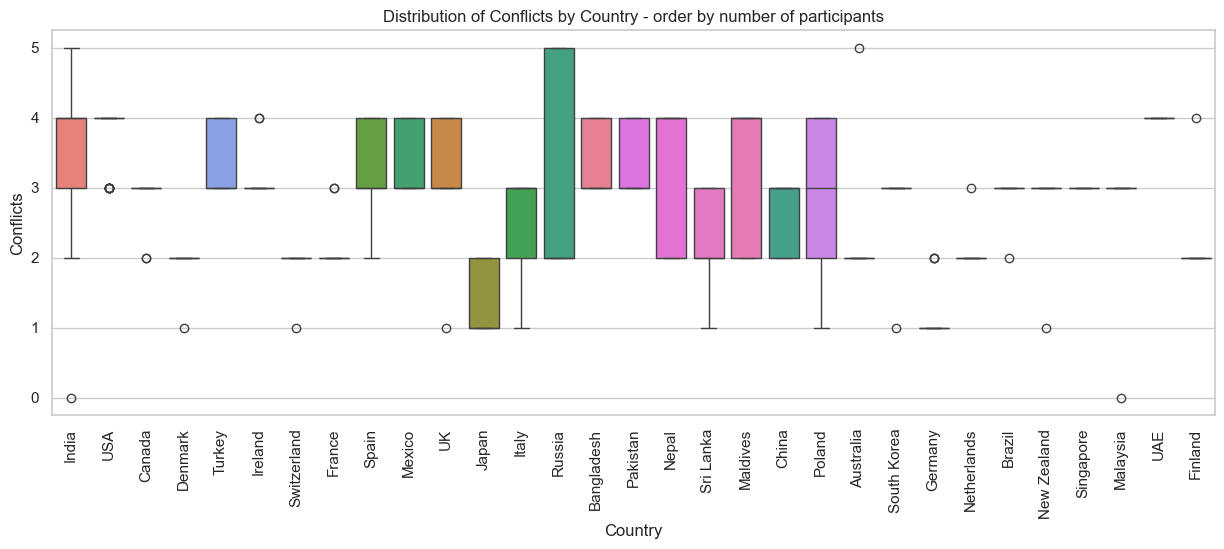

In [27]:
target_col = 'Conflicts'

boxplot_by_category_long_tail(df_data, 'Platform', target_col)

# boxplot for countries with more than 1 participant
df_data_country = df_data[df_data['Country'].isin(df_data['Country'].value_counts()[df_data['Country'].value_counts() > 1].index)]
boxplot_by_category_long_tail(df_data_country, 'Country', target_col)

# Inspecting the class imbalance for the Social Media Conflicts
- **Binary Conflict Variable**:
    - Grouping the conflicts into 2 classes (0-3 vs 4-5) shows a class imbalance ratio of 2.73:1.
    - Grouping the conflicts into 3 classes (0-2 vs 3 vs 4-5) shows a weaker class imbalance ratio of 1.76:1.
- **3 Class Conflict Variable**:
    - The 3-class mapping of conflicts target (0-2 vs 3 vs 4-5) shows a class imbalance ratio of 1.37:1.
- A 3-class mapping of target conflicts variable is more balanced and interpretable compare to the binary mapping.
- Among binary classification settings, the one with conflicts < 3 against the rest shows a better class balance.
- A 2-class problem is less complex than a 3-class one, but it might need data downsampling or oversampling to avoid overfitting.



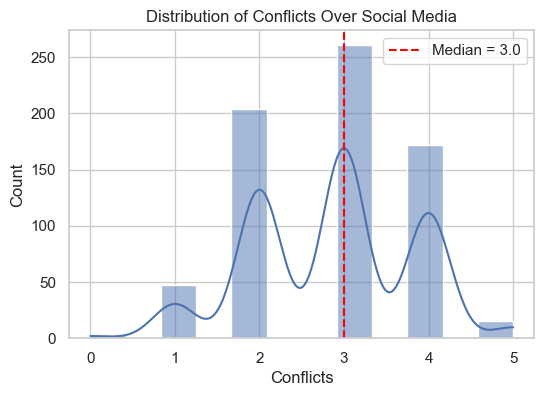

Binary Conflict Distribution: (0-3) vs (4-5)
Conflict_Binary
Low     515
High    187
Name: count, dtype: int64
Class imbalance ratio: 2.75


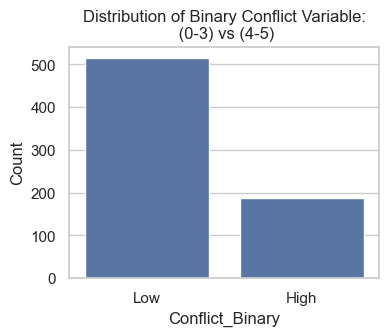

Binary Conflict Distribution: (0-2) vs (3-5)
Conflict_Binary
High    448
Low     254
Name: count, dtype: int64
Class imbalance ratio: 1.76


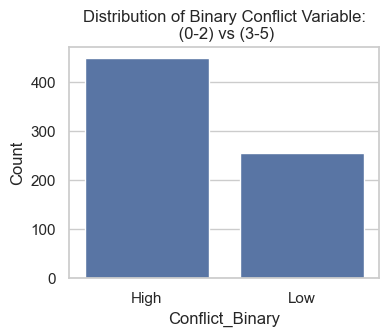

3 Class Conflict Distribution: (0-2) vs (3) vs (4-5)
Conflict_3_Class
Medium    261
Low       254
High      187
Name: count, dtype: int64
Class imbalance ratio: 1.40


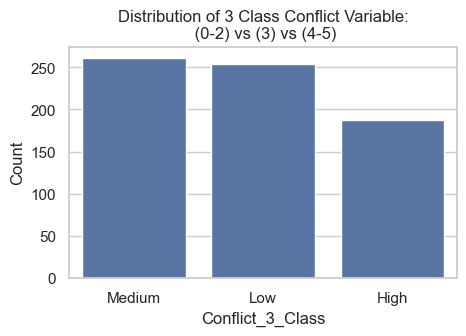

In [29]:
# 1. Convert Conflicts_Over_Social_Media into binary categories
# First, let's examine the distribution to determine a meaningful threshold
plt.figure(figsize=(6, 4))
sns.histplot(df_data['Conflicts'], kde=True)
plt.axvline(df_data['Conflicts'].median(), color='red', linestyle='--', 
           label=f'Median = {df_data["Conflicts"].median()}')
plt.title('Distribution of Conflicts Over Social Media')
plt.legend()
plt.show()

def create_binary_conflic(df, threshold):
    # Create binary target variable based on median split
    # median_conflict = df_data['Conflicts'].median()
    df['Conflict_Binary'] = df['Conflicts'].apply(
        lambda x: 'High' if x > threshold else 'Low'
    )

    # Check the distribution of the binary variable
    conflict_counts = df['Conflict_Binary'].value_counts()
    print(f"Binary Conflict Distribution: ({0}-{threshold}) vs ({threshold+1}-5)")
    print(conflict_counts)
    print(f"Class imbalance ratio: {conflict_counts.max() / conflict_counts.min():.2f}")

    # Visualize the binary distribution
    plt.figure(figsize=(4, 3))
    sns.countplot(data=df, x='Conflict_Binary')
    plt.title(f'Distribution of Binary Conflict Variable:\n ({0}-{threshold}) vs ({threshold+1}-5)')
    plt.ylabel('Count')
    plt.show()

create_binary_conflic(df_data, 3)
create_binary_conflic(df_data, 2)

# a 3 class mapping
df_data['Conflict_3_Class'] = df_data['Conflicts'].apply(
    lambda x: 'High' if x >= 4 else 'Medium' if x == 3  else 'Low'
)

# Check the distribution of the 3 class variable
conflict_counts = df_data['Conflict_3_Class'].value_counts()
print(f"3 Class Conflict Distribution: ({0}-2) vs (3) vs ({4}-5)")
print(conflict_counts)
print(f"Class imbalance ratio: {conflict_counts.max() / conflict_counts.min():.2f}")
# Plot the 3 class distribution
plt.figure(figsize=(5, 3))
sns.countplot(data=df_data, x='Conflict_3_Class')
plt.title('Distribution of 3 Class Conflict Variable:\n (0-2) vs (3) vs (4-5)')
plt.ylabel('Count')
plt.show()

# Encoding categorical variables
We use the following encoding methods:
- Binary encoding for binary categorical variables
- One-hot encoding for categorical variables with more than 2 categories while leaving the smallest category as "others"
- Frequency encoding for categorical variables with high cardinality

## Binary Feature
Binary encoding is used for gender

Gender encoding:
Female -> 0
Male -> 1


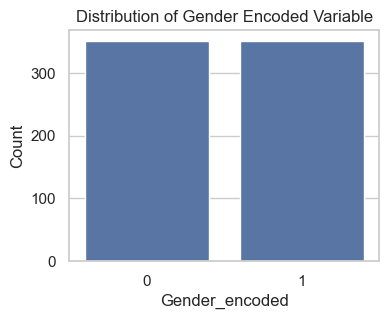

In [30]:
# Categorical Feature Encoding

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import pandas as pd

# Create a copy of the dataframe for encoding
df_encoded = df_data.copy()

# 1. Binary encoding for Gender
le_gender = LabelEncoder()
df_encoded['Gender_encoded'] = le_gender.fit_transform(df_encoded['Gender'])
print("Gender encoding:")
print(f"Female -> {le_gender.transform(['Female'])[0]}")
print(f"Male -> {le_gender.transform(['Male'])[0]}")

# plot the distribution of the encoded variable
plt.figure(figsize=(4, 3))
sns.countplot(data=df_encoded, x='Gender_encoded')
plt.title('Distribution of Gender Encoded Variable')
plt.ylabel('Count')
plt.show()


## One-hot encoding for categorical features
- We use the one-hot encoding for Relationship_Status and Academic_Level.
- The minority category is encoded as 'other'.

In [31]:
# 2. One-hot encoding for Relationship_Status and Academic_Level
def encode_onehot_with_reference(df, column_name, prefix=None):
    """One-hot encoding with smallest category as reference (dropped)"""
    counts = df[column_name].value_counts()
    smallest_category = counts.index[-1]  # Get smallest category
    
    print(f"\n Encoding {column_name} with prefix {prefix}")
    print(f"Reference category (dropped): {smallest_category}")
    
    # Create one-hot encoded columns
    dummies = pd.get_dummies(df[column_name], prefix=prefix or column_name, drop_first=False)
    # Drop smallest category as reference
    dummies = dummies.drop(f'{prefix or column_name}_{smallest_category}', axis=1)

    # print the first 5 rows of the encoded variable
    print(dummies.head())

   
    # Concatenate with original dataframe
    df = pd.concat([df, dummies], axis=1)

    # print samples of the other category
    print(f"\nSamples of the other category:")
    mask = df[column_name] == smallest_category
    print(pd.concat([df[mask][[column_name]], dummies[mask]], axis=1).head())

    return df, dummies

# For Relationship_Status - find the smallest category to use as 'other'
df_encoded, dummies_rel = encode_onehot_with_reference(df_encoded, 'Relationship_Status', 'Relationship')

# For Academic_Level - find the smallest category to use as 'other'
df_encoded, dummies_acad = encode_onehot_with_reference(df_encoded, 'Academic_Level', 'Academic')



 Encoding Relationship_Status with prefix Relationship
Reference category (dropped): Complicated
   Relationship_In Relationship  Relationship_Single
0                          True                False
1                         False                 True
2                         False                False
3                         False                 True
4                          True                False

Samples of the other category:
   Relationship_Status  Relationship_In Relationship  Relationship_Single
2          Complicated                         False                False
5          Complicated                         False                False
10         Complicated                         False                False
15         Complicated                         False                False
19         Complicated                         False                False

 Encoding Academic_Level with prefix Academic
Reference category (dropped): High School
   Academic_Graduat

## Grouping Platforms
- Platforms with fewer than 30 participants are grouped into an 'Other' category.
- The 'Other' category contains approximately 100 participants.

Platform_group
Instagram    248
TikTok       153
Facebook     123
Other         94
WhatsApp      54
Twitter       30
Name: count, dtype: int64


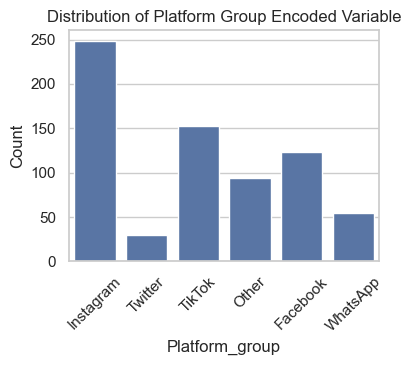

,Platform,Platform_Facebook,Platform_Instagram,Platform_Other,Platform_TikTok,Platform_Twitter,Platform_WhatsApp
0,Instagram,False,True,False,False,False,False
1,Twitter,False,False,False,False,True,False
2,TikTok,False,False,False,True,False,False
3,YouTube,False,False,True,False,False,False
4,Facebook,True,False,False,False,False,False


In [32]:
# Grouping Platforms with category size less than 10% of the total

# group the platforms with category size less than 10% of the total
df_encoded['Platform_group'] = df_encoded['Platform'].apply(lambda x: 'Other' if df_encoded['Platform'].value_counts()[x] < 30 else x)

# print the distribution of the platform_group variable
print(df_encoded['Platform_group'].value_counts())

# plot the distribution of the Platform_group variable
plt.figure(figsize=(4, 3))
sns.countplot(data=df_encoded, x='Platform_group')
plt.title('Distribution of Platform Group Encoded Variable')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# one-hot encode the platform_group variable
df_encoded = pd.get_dummies(df_encoded, columns=['Platform_group'], prefix='Platform')
# print(df_encoded['Platform_group'].head())

col_platform_group = [col for col in df_encoded.columns if 'Platform' in col]
df_encoded[col_platform_group].head()

## Encoding Country 

### Grouping Non-Dominant Countries
- Countries with fewer than 20 participants are grouped into a single 'Other' category.
- The 'Other' category currently contains 283 participants, which is 5 times bigger than the largest category.


Country_group
Other          283
India           53
USA             38
Canada          34
France          27
Spain           27
Mexico          27
Denmark         27
Switzerland     27
Ireland         27
Turkey          27
UK              22
Japan           21
Italy           21
Russia          21
Bangladesh      20
Name: count, dtype: int64


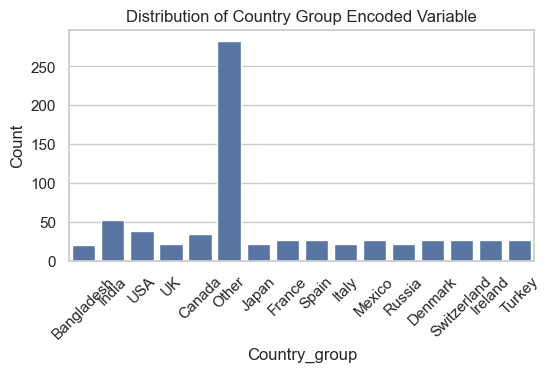

,Country,Country_Bangladesh,Country_Canada,Country_Denmark,Country_France,Country_India,Country_Ireland,Country_Italy,Country_Japan,Country_Mexico,Country_Other,Country_Russia,Country_Spain,Country_Switzerland,Country_Turkey,Country_UK,Country_USA
0,Bangladesh,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,India,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False
2,USA,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
3,UK,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,Canada,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [33]:
# Grouping Platforms with category size less than 10% of the total

# group the country with category size less than 10% of the total
df_encoded['Country_group'] = df_encoded['Country'].apply(
    lambda x: 'Other' if df_encoded['Country'].value_counts()[x] < 20 else x
    )

# print the distribution of the platform_group variable
print(df_encoded['Country_group'].value_counts())

# plot the distribution of the Platform_group variable
plt.figure(figsize=(6, 3))
sns.countplot(data=df_encoded, x='Country_group')
plt.title('Distribution of Country Group Encoded Variable')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

# one-hot encode the platform_group variable
df_encoded = pd.get_dummies(df_encoded, columns=['Country_group'], prefix='Country')
# print(df_encoded['Platform_group'].head())

col_platform_group = [col for col in df_encoded.columns if 'Country' in col]
df_encoded[col_platform_group].head()

### Frequency encoding 
- Encoding the country variable with frequency encoding.
- Several countries have 27 participants, which makes this encoded value dominant.
- This encoding is shows lower cardinality than grouping while not interpretable.


Country frequency encoding (top 5):
India: 53
USA: 38
Canada: 34
Turkey: 27
Mexico: 27

Country frequency encoded variable (top 5):
   Country_freq_encoded
0                    20
1                    53
2                    38
3                    22
4                    34


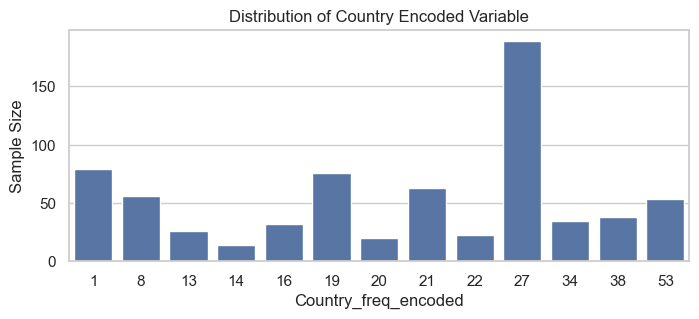

In [38]:
# 3. Frequency-based encoding for Country and Platform
def encode_frequency(df, column_name):
    freq = df[column_name].value_counts().to_dict()
    df[f'{column_name}_freq_encoded'] = df[column_name].map(freq)

    # print the first 5 rows of the encoding mapping   
    print(f"\n{column_name} frequency encoding (top 5):")
    for country, freq in list(freq.items())[:5]:
        print(f"{country}: {freq}")

    # print the first 5 rows of the encoded variable
    print(f"\n{column_name} frequency encoded variable (top 5):")
    print(df[[f'{column_name}_freq_encoded']].head())

    # plot encoded variable distribution
    plt.figure(figsize=(8, 3))
    sns.countplot(data=df, x=f'{column_name}_freq_encoded')
    plt.title(f'Distribution of {column_name} Encoded Variable')
    plt.ylabel('Sample Size')
    plt.show()

    return df

# Country frequency encoding
df_encoded =  encode_frequency(df_encoded, 'Country')
# df_encoded =  encode_frequency(df_encoded, 'Platform')
# df_encoded

## Continent-Based Encoding for Country
- We encode the 'Country' variable by mapping each country to its respective continent.
- The resulting bar plot of conflicts by continent reveals a balanced distribution for Europe, while North America and Asia exhibit notably higher conflict levels.

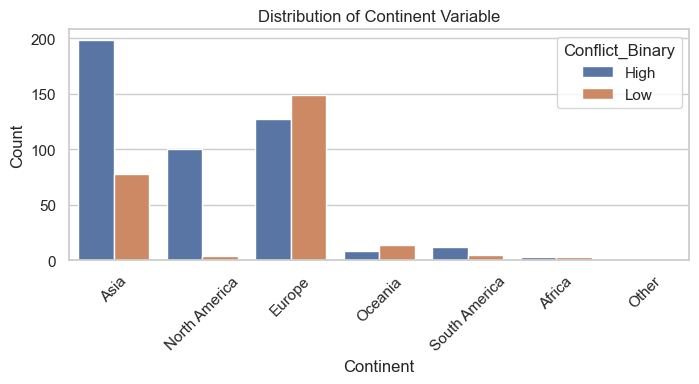

In [35]:
# Grouping countries by continent
df_data = map_to_continent(df_data)

#  visualize
plt.figure(figsize=(8, 3))
sns.countplot(data=df_data, x='Continent', hue='Conflict_Binary')
plt.title('Distribution of Continent Variable')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

